In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
from scipy import stats
import numpy as np

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV


import seaborn as sns


<h1>Dataframe preparations</h1>

In [186]:
merged_df = pd.read_csv('/Users/rgu/Desktop/UROPs/UROP4/repo/dataframes/final505.csv')

In [165]:
display(merged_df)

,song_name,genre,speaker_id,dry_weight,weight0,weight1,weight2,water_loss1,water_loss2,total_water_loss,...,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,chroma_stft_mean,chroma_stft_var
0,blues.00000.wav,blues,1,1.6970,2.3791,2.3622,2.3454,0.0169,0.0168,0.0337,...,1784.165850,1.297741e+05,2002.449060,85882.76132,3805.839606,9.015054e+05,0.083045,0.000767,0.350088,0.088757
1,blues.00000.wav,blues,2,2.2398,3.0993,3.0800,3.0604,0.0193,0.0196,0.0389,...,1784.165850,1.297741e+05,2002.449060,85882.76132,3805.839606,9.015054e+05,0.083045,0.000767,0.350088,0.088757
2,blues.00001.wav,blues,1,2.0938,2.9459,2.9327,2.9131,0.0132,0.0196,0.0328,...,1530.176679,3.758501e+05,2039.036516,213843.75550,3550.522098,2.977893e+06,0.056040,0.001448,0.340914,0.094980
3,blues.00001.wav,blues,2,1.7753,2.5336,2.5183,2.4888,0.0153,0.0295,0.0448,...,1530.176679,3.758501e+05,2039.036516,213843.75550,3550.522098,2.977893e+06,0.056040,0.001448,0.340914,0.094980
4,blues.00002.wav,blues,1,1.9536,2.7848,2.7713,2.7591,0.0135,0.0122,0.0257,...,1552.811865,1.564676e+05,1747.702312,76254.19226,3042.260232,7.840345e+05,0.076291,0.001007,0.363637,0.085275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,rock.00048.wav,rock,2,1.6663,2.5072,2.4905,2.4763,0.0167,0.0142,0.0309,...,1646.212074,1.182595e+05,1700.799670,53274.51547,3183.841459,5.062808e+05,0.085253,0.000780,0.321645,0.081702
1006,rock.00049.wav,rock,1,1.3199,1.9942,1.9813,1.9713,0.0129,0.0100,0.0229,...,2077.942607,1.216625e+06,2333.872696,694784.81150,4495.809731,6.649790e+06,0.091334,0.002918,0.396285,0.077750
1007,rock.00049.wav,rock,2,1.8025,2.6722,2.6558,2.6467,0.0164,0.0091,0.0255,...,2077.942607,1.216625e+06,2333.872696,694784.81150,4495.809731,6.649790e+06,0.091334,0.002918,0.396285,0.077750
1008,rock.00050.wav,rock,1,1.4875,2.1825,2.1689,2.1586,0.0136,0.0103,0.0239,...,1721.088460,7.007705e+05,2312.314590,366475.40300,3811.160455,3.938340e+06,0.053303,0.001456,0.394481,0.089190


<h1>Clustering</h1>

In [159]:
#Determine the colors of the points
colormap = {'blues': 'blue', 
          'classical': 'brown', 
          'country': 'orange', 
          'disco': 'purple', 
          'hiphop': 'skyblue', 
          'jazz': 'khaki', 
          'metal': 'black', 
          'pop': 'deeppink', 
          'reggae': 'green', 
          'rock': 'red'}

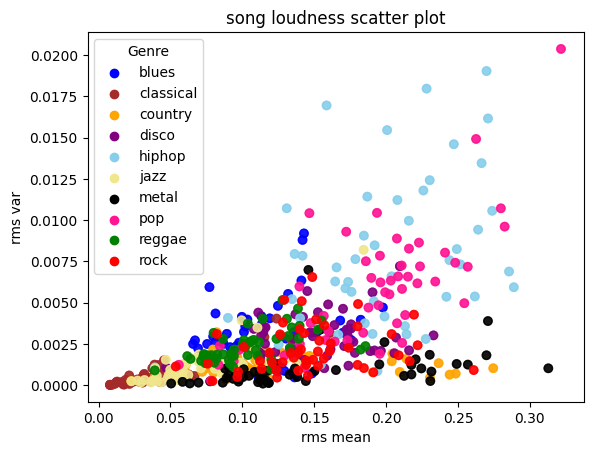

In [177]:
#plot the songs by RMS amplitude mean and variance as the axes. The points will be color coded by genre
x = merged_df['rms_mean']
y = merged_df['rms_var']
colors = merged_df['genre'].map(colormap)

plt.scatter(x, y, c=colors, alpha=0.7)  

plt.xlabel('rms mean')
plt.ylabel('rms var')
plt.title('song loudness scatter plot')


for genre, color in colormap.items():
    plt.scatter([], [], c=color, label=genre)
plt.legend(title="Genre")

plt.show()


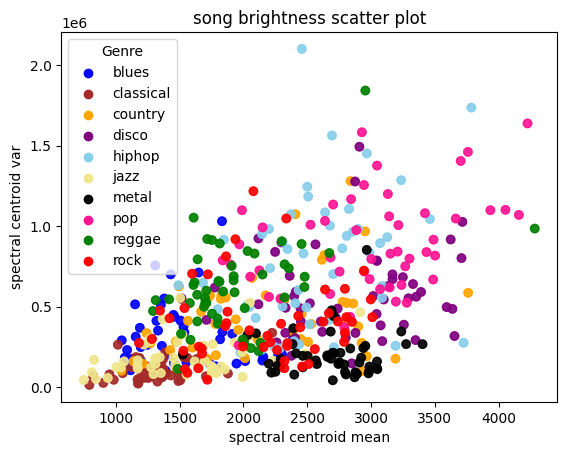

In [178]:
#plot the songs by spectral centroid mean and variance as the axes. The points will be color coded by genre
x = merged_df['spectral_centroid_mean']
y = merged_df['spectral_centroid_var']
colors = merged_df['genre'].map(colormap)

plt.scatter(x, y, c=colors, alpha=0.7)  

plt.xlabel('spectral centroid mean')
plt.ylabel('spectral centroid var')
plt.title('song brightness scatter plot')


for genre, color in colormap.items():
    plt.scatter([], [], c=color, label=genre)
plt.legend(title="Genre")

plt.show()

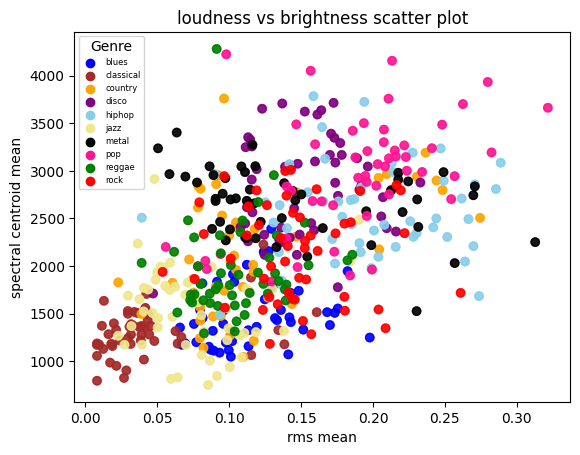

In [179]:
#plot the songs by RMS amplitude mean and spectral centroid as the axes. The points will be color coded by genre
x = merged_df['rms_mean']
y = merged_df['spectral_centroid_mean']
colors = merged_df['genre'].map(colormap)

plt.scatter(x, y, c=colors, alpha=0.7)  

plt.xlabel('rms mean')
plt.ylabel('spectral centroid mean')
plt.title('loudness vs brightness scatter plot')


for genre, color in colormap.items():
    plt.scatter([], [], c=color, label=genre)
plt.legend(title="Genre", fontsize="6")

plt.show()

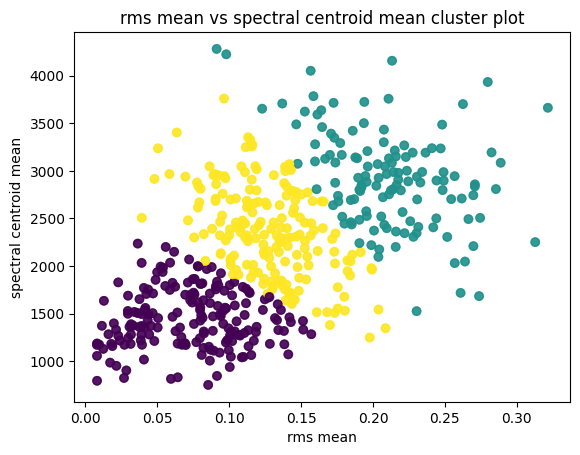

In [181]:
#Cluster plot: rms amplitude mean vs spectral centroid mean

features = merged_df[['rms_mean', 'spectral_centroid_mean']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(scaled_features)

plt.scatter(merged_df['rms_mean'], merged_df['spectral_centroid_mean'], c=clusters, cmap='viridis', alpha=0.7) #viridis is a type of colormap

plt.xlabel('rms mean')
plt.ylabel('spectral centroid mean')
plt.title("rms mean vs spectral centroid mean cluster plot")

plt.show()

<h1>Assumptions Testing</h1>

In [172]:
#Shapiro-Wilk Test to check for normality
#residuals = model_test.resid

stat, p_value = stats.shapiro(merged_df['total_water_loss'])

print("Shapiro-Wilk Test Statistic:", stat)
print("P-Value:", p_value)

if p_value > 0.05:
    print("The data is normally distributed (fail to reject H₀).")
else:
    print("The data is not normally distributed (reject H₀).")

Shapiro-Wilk Test Statistic: 0.9761261864085752
P-Value: 7.874178903555918e-12
The data is not normally distributed (reject H₀).


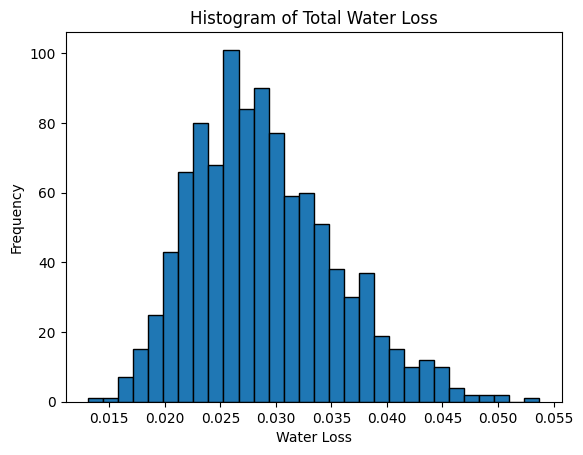

In [167]:
plt.hist(merged_df['total_water_loss'], bins=30, edgecolor='black')
plt.title('Histogram of Total Water Loss')
plt.xlabel('Water Loss')
plt.ylabel('Frequency')
plt.show()

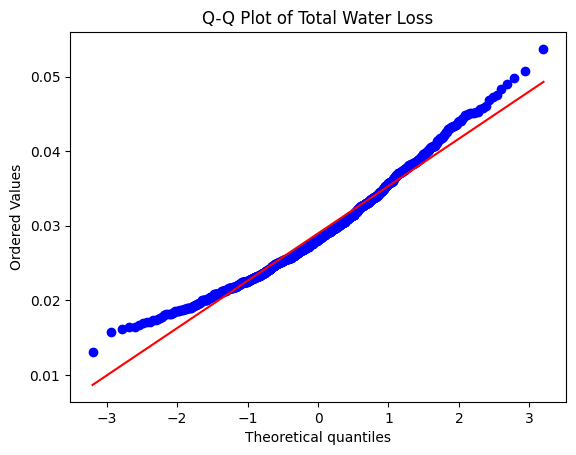

In [168]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(merged_df['total_water_loss'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Total Water Loss')
plt.show()


In [8]:
#depricated, but was used to remove datapoint outliers that were 3 std away from the mean. in this case we used in terms of residuals

# std_deviation = np.std(residuals)
# mean_residual = np.mean(residuals)
# threshold = 3  # This can be adjusted

# outliers = merged_df[np.abs(residuals) > (mean_residual + threshold * std_deviation)]
# print("Outliers:")
# print(outliers)

In [173]:
genres = merged_df['genre'].unique()  #get the unique genre names
groups = [merged_df[merged_df['genre'] == genre]['total_water_loss'] for genre in genres]
stat, p_value = stats.levene(*groups)
print("Levene's Test Statistic:", stat)
print("P-Value:", p_value)

if p_value > 0.05:
    print("Variances are equal across groups (fail to reject H₀).")
else:
    print("Variances are significantly different across groups (reject H₀).")

Levene's Test Statistic: 2.6753861233026157
P-Value: 0.004501396519727931
Variances are significantly different across groups (reject H₀).


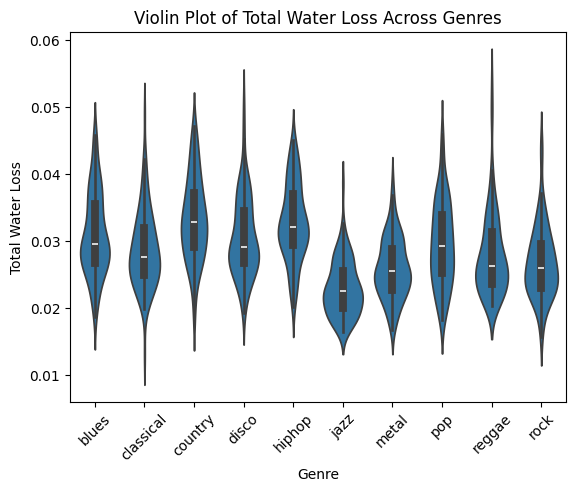

In [174]:
sns.violinplot(x='genre', y='total_water_loss', data=merged_df)
plt.title('Violin Plot of Total Water Loss Across Genres')
plt.xlabel('Genre')
plt.ylabel('Total Water Loss')
plt.xticks(rotation=45)
plt.show()

In [ ]:
for variable in ['rms_mean', 'rms_var', 
                  'spectral_centroid_mean', 'spectral_centroid_var', 
                  'spectral_bandwidth_mean', 'spectral_bandwidth_var',
                  'zero_crossing_rate_mean', 'zero_crossing_rate_var',
                  'chroma_stft_mean', 'chroma_stft_var',
                  'rolloff_mean', 'rolloff_var', 'tempo']:
    stat, p_value = stats.shapiro(merged_df[variable])

    print(stat, p_value)

    if p_value > 0.05:
        print("The data is normally distributed (fail to reject H₀).")
    else:
        print("The data is not normally distributed (reject H₀).")

    plt.hist(merged_df[variable], bins=30, edgecolor='black')
    plt.title(f'Histogram of {variable}')
    plt.xlabel(f'{variable}')
    plt.ylabel('Frequency')
    plt.show()

<h1>Welch's ANOVA</h1>



<h3>Independent: song_name,  Dependent: total 
water loss </h3>

In [176]:
welch_anova_results = pg.welch_anova(dv='total_water_loss', between='genre', data=merged_df)

print(welch_anova_results)

  Source  ddof1       ddof2         F         p-unc       np2
0  genre      9  406.881629  41.02769  7.099962e-52  0.224306


<h1>Spearman's Rank Correlation</h1>

In [187]:
corr_matrix = merged_df[['rms_mean', 'rms_var', 
                  'spectral_centroid_mean', 'spectral_centroid_var', 
                  'spectral_bandwidth_mean', 'spectral_bandwidth_var',
                  'zero_crossing_rate_mean', 'zero_crossing_rate_var',
                  'rolloff_mean', 'rolloff_var',
                   'total_water_loss']].corr(method='spearman') # Calculate Spearman correlation

print(corr_matrix)

                         rms_mean   rms_var  spectral_centroid_mean  \
rms_mean                 1.000000  0.619877                0.573844   
rms_var                  0.619877  1.000000                0.256805   
spectral_centroid_mean   0.573844  0.256805                1.000000   
spectral_centroid_var    0.362458  0.588044                0.490318   
spectral_bandwidth_mean  0.591558  0.355861                0.911984   
spectral_bandwidth_var   0.152783  0.456038                0.067559   
zero_crossing_rate_mean  0.428531  0.081865                0.899909   
zero_crossing_rate_var   0.384894  0.506123                0.705721   
rolloff_mean             0.598446  0.294247                0.984141   
rolloff_var              0.247073  0.534813                0.221163   
total_water_loss         0.339729  0.283951                0.142810   

                         spectral_centroid_var  spectral_bandwidth_mean  \
rms_mean                              0.362458                 0.591558 

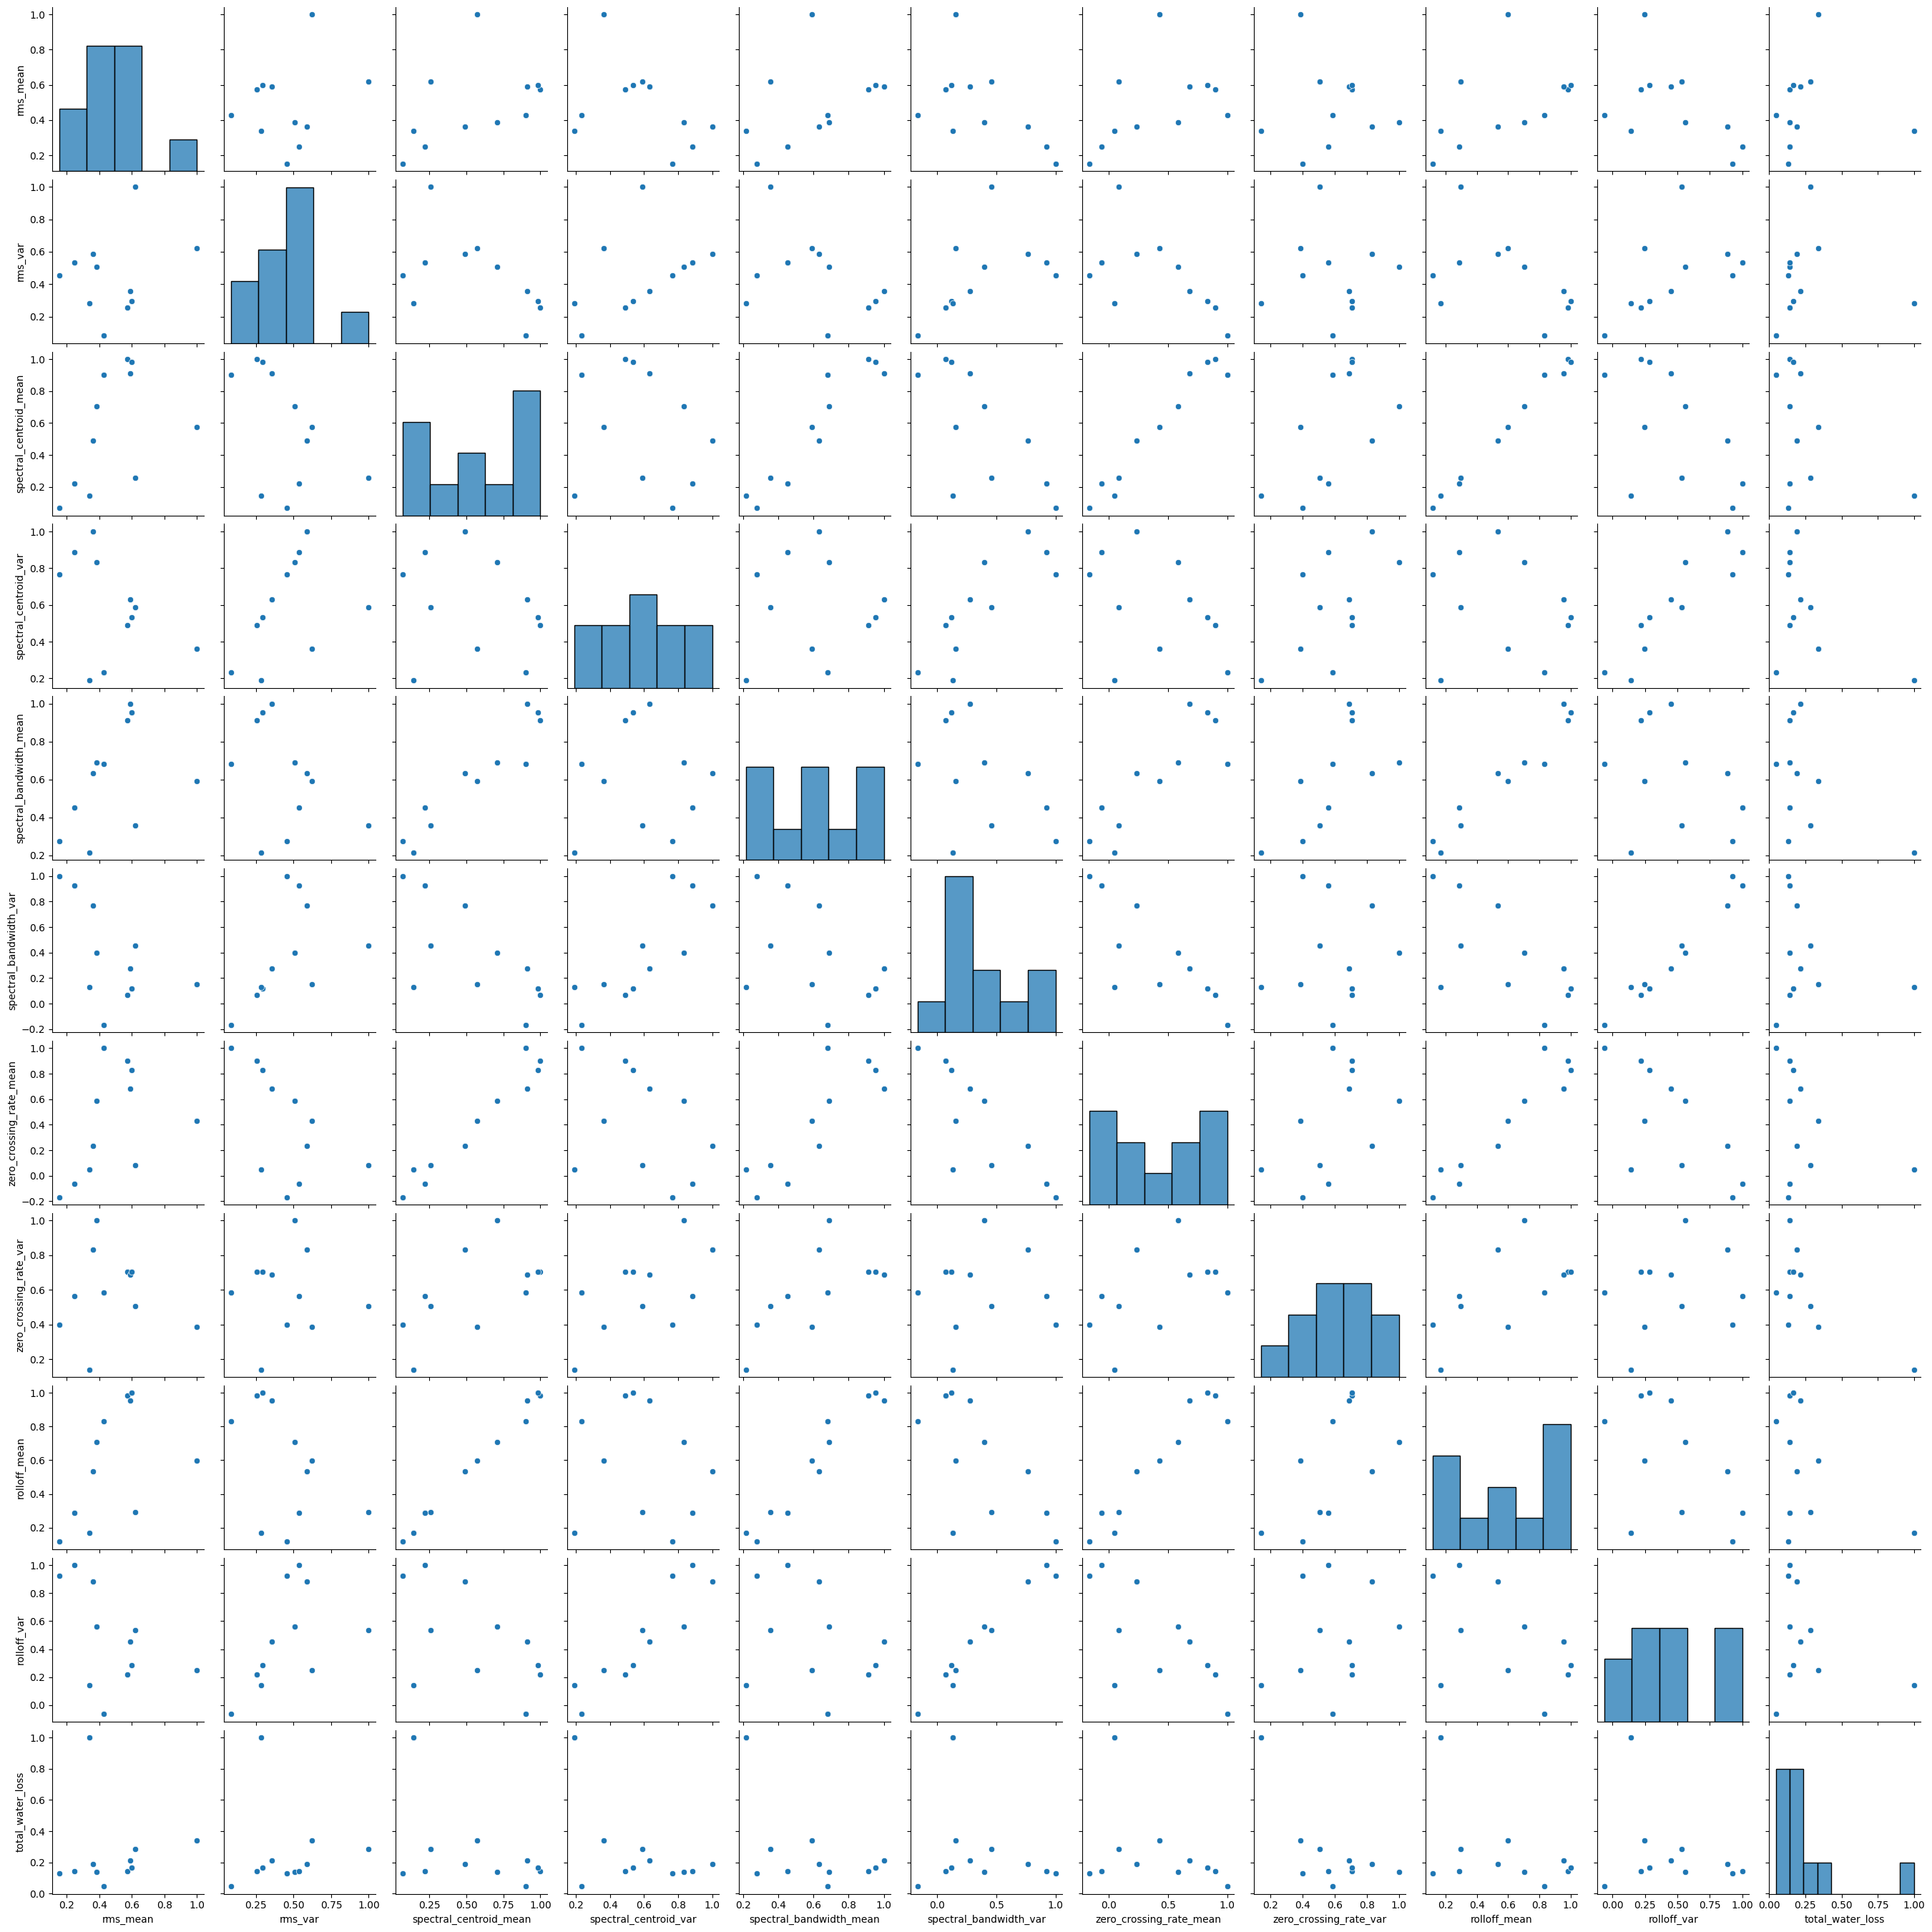

In [183]:
sns.pairplot(corr_matrix)
plt.show()

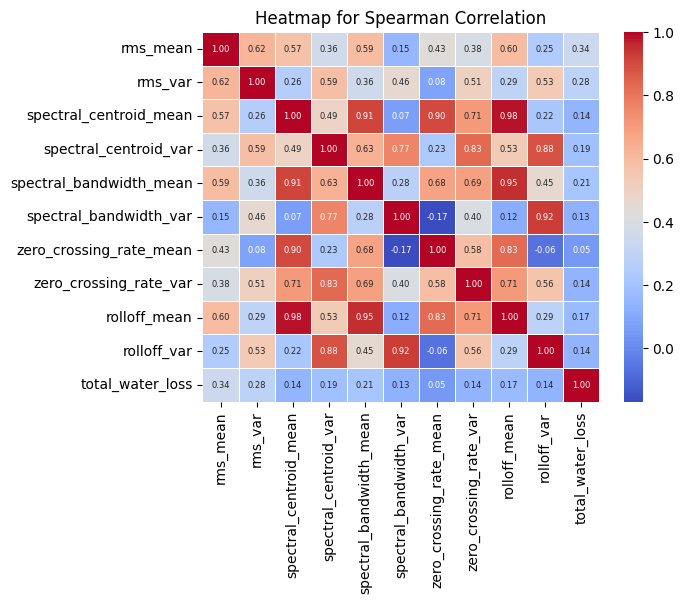

In [189]:
# Plot a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt = '.2f', linewidths = 0.5, annot_kws={"size": 6})
plt.title('Heatmap for Spearman Correlation')
plt.show()

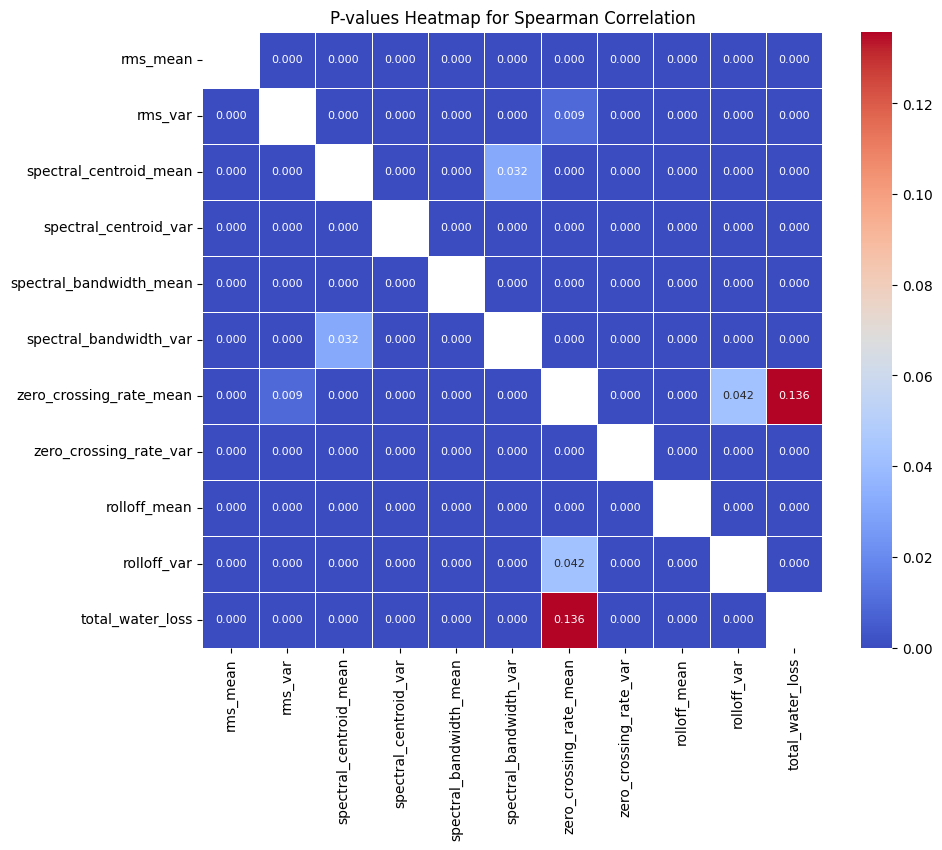

In [190]:
data = merged_df[['rms_mean', 'rms_var', 
                  'spectral_centroid_mean', 'spectral_centroid_var', 
                  'spectral_bandwidth_mean', 'spectral_bandwidth_var',
                  'zero_crossing_rate_mean', 'zero_crossing_rate_var',
                  'rolloff_mean', 'rolloff_var',
                  'total_water_loss']]

p_values = pd.DataFrame(np.zeros((data.shape[1], data.shape[1])), columns=data.columns, index=data.columns)

#compute spearman for each pair of variables, store it in a dataframe
for col1 in data.columns:
    for col2 in data.columns:
        if col1 != col2:
            rho, p = stats.spearmanr(data[col1], data[col2])
            p_values.loc[col1, col2] = p
        else:
            p_values.loc[col1, col2] = np.nan  #diagonals should be Nan


plt.figure(figsize=(10, 8))
sns.heatmap(p_values, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5, annot_kws={"size": 8})
plt.title('P-values Heatmap for Spearman Correlation')
plt.show()

<h1>PCA</h1>

In [191]:
outputs = merged_df[['rms_mean', 'rms_var', 
                  'spectral_centroid_mean', 'spectral_centroid_var', 
                  'spectral_bandwidth_mean', 'spectral_bandwidth_var',
                  'zero_crossing_rate_mean', 'zero_crossing_rate_var',
                  'rolloff_mean', 'rolloff_var']]

In [192]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(outputs)

In [193]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
print(principal_components)

[[-1.4898733  -0.5317275 ]
 [-1.4898733  -0.5317275 ]
 [-1.13510415  1.59198094]
 ...
 [ 2.28713479  5.693795  ]
 [ 0.3693232   3.08258394]
 [ 0.3693232   3.08258394]]


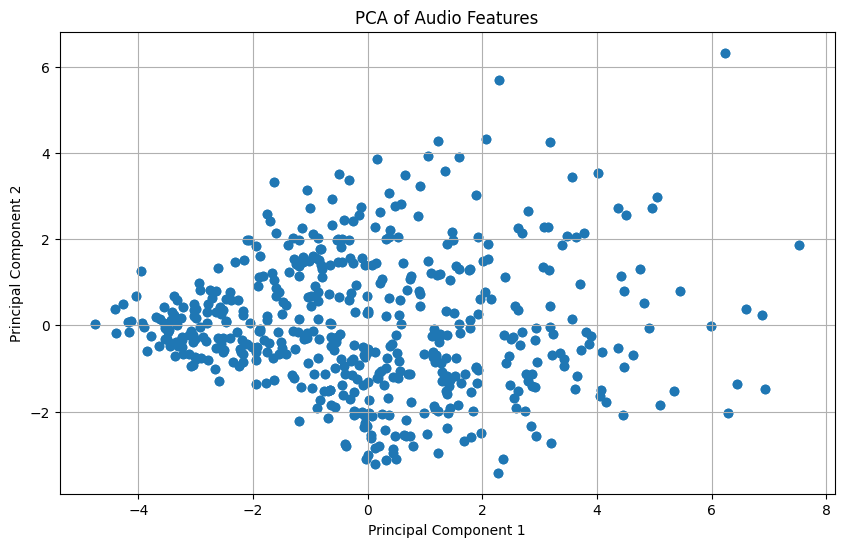

In [195]:
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.title('PCA of Audio Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

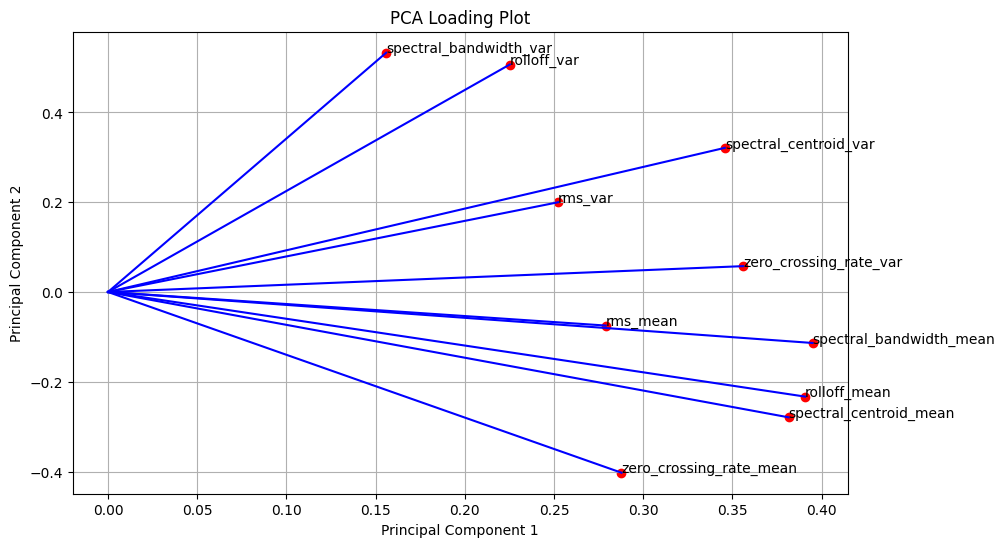

In [197]:
loadings = pca.components_

plt.figure(figsize=(10, 6))
plt.scatter(loadings[0, :], loadings[1, :], color='red')
for i in range(loadings.shape[1]):
    plt.plot([0, loadings[0, i]], [0, loadings[1, i]], 'blue')

feature_names = ['rms_mean', 'rms_var', 
                  'spectral_centroid_mean', 'spectral_centroid_var', 
                  'spectral_bandwidth_mean', 'spectral_bandwidth_var',
                  'zero_crossing_rate_mean', 'zero_crossing_rate_var',
                  'rolloff_mean', 'rolloff_var']

for i, feature in enumerate(feature_names):
    plt.text(loadings[0, i], loadings[1, i], feature)

plt.title('PCA Loading Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [198]:
#create pca dataframe
pca_df = pd.DataFrame(principal_components, columns=[f"PCA_{i}" for i in range(1, principal_components.shape[1]+1)])
pca_df['total_water_loss'] = merged_df['total_water_loss']
display(pca_df)

,PCA_1,PCA_2,total_water_loss
0,-1.489873,-0.531727,0.0337
1,-1.489873,-0.531727,0.0389
2,-1.135104,1.591981,0.0328
3,-1.135104,1.591981,0.0448
4,-1.816801,-0.339501,0.0257
...,...,...,...
1005,-2.172097,-0.851224,0.0309
1006,2.287135,5.693795,0.0229
1007,2.287135,5.693795,0.0255
1008,0.369323,3.082584,0.0239


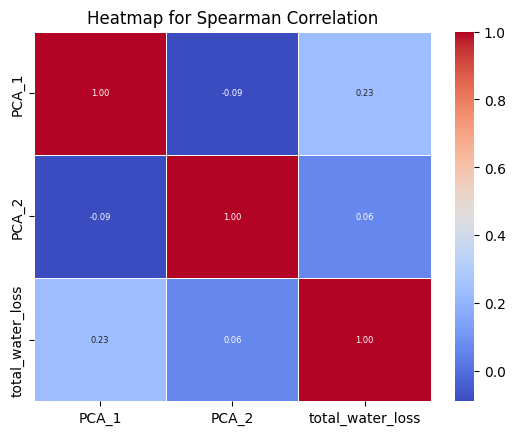

In [200]:
pca_corr = pca_df.corr(method='spearman')
sns.heatmap(pca_corr, annot=True, cmap='coolwarm', fmt = '.2f', linewidths = 0.5, annot_kws={"size": 6})
plt.title('Heatmap for Spearman Correlation')
plt.show()

<h1>OLS Regression and VIFs</h1>

In [205]:
X = merged_df[['rms_mean', 'rms_var', 
               'spectral_centroid_mean', 'spectral_centroid_var', 
               'spectral_bandwidth_mean', 'spectral_bandwidth_var',
               'zero_crossing_rate_mean', 'zero_crossing_rate_var',
               'rolloff_mean', 'rolloff_var',
               ]]

y = merged_df['total_water_loss']

In [206]:
#do regular OLS for comparison
model = sm.OLS(y, X).fit()
print(model.summary())


                                 OLS Regression Results                                
Dep. Variable:       total_water_loss   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              2162.
Date:                Tue, 20 Aug 2024   Prob (F-statistic):                        0.00
Time:                        02:03:51   Log-Likelihood:                          3694.8
No. Observations:                1010   AIC:                                     -7370.
Df Residuals:                    1000   BIC:                                     -7320.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [207]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [208]:
display(vif_data)

,Feature,VIF
0,rms_mean,12.083248
1,rms_var,4.281413
2,spectral_centroid_mean,1938.707496
3,spectral_centroid_var,61.761173
4,spectral_bandwidth_mean,203.156603
5,spectral_bandwidth_var,16.313503
6,zero_crossing_rate_mean,196.056202
7,zero_crossing_rate_var,21.779321
8,rolloff_mean,675.644438
9,rolloff_var,35.815337


<h1>Ridge Regression</h1>

In [215]:
X = merged_df[['rms_mean', 'rms_var', 
               'spectral_centroid_mean', 'spectral_centroid_var', 
               'spectral_bandwidth_mean', 'spectral_bandwidth_var',
               'zero_crossing_rate_mean', 'zero_crossing_rate_var',
               'rolloff_mean', 'rolloff_var',
               ]]

y = merged_df['total_water_loss']

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [217]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [218]:
ridge_reg = Ridge(alpha=3.5564803062231287)

#train the model
ridge_reg.fit(X_train_scaled, y_train)


Ridge(alpha=3.5564803062231287)

In [219]:
y_pred = ridge_reg.predict(X_test_scaled)


In [220]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")


Mean Squared Error: 3.333773034988783e-05
R-squared: 0.16004387290004152


In [221]:
#cross validation for best alpha
param_grid = {'alpha': np.logspace(-3, 3, 50)} 
grid_search = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

#fit the model on the training data
grid_search.fit(X_train_scaled, y_train)

#get best ridge model
best_ridge = grid_search.best_estimator_

#find best alpha value
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

Best alpha: 3.5564803062231287


In [223]:
coefficients = pd.Series(ridge_reg.coef_, index=X.columns)
print(coefficients)


rms_mean                   0.001678
rms_var                    0.000943
spectral_centroid_mean    -0.000966
spectral_centroid_var      0.000961
spectral_bandwidth_mean    0.003458
spectral_bandwidth_var     0.000778
zero_crossing_rate_mean   -0.000626
zero_crossing_rate_var     0.000081
rolloff_mean              -0.002275
rolloff_var               -0.002127
dtype: float64


<h1>Recursive Feature Elimination</h1>

In [225]:
raw_df = pd.read_csv("/Users/rgu/Desktop/UROPs/UROP4/repo/dataframes/raw505.csv")

In [230]:
from sklearn.feature_selection import RFE


X = raw_df[['rms_mean', 'rms_var', 
               'spectral_centroid_mean', 'spectral_centroid_var', 
               'spectral_bandwidth_mean', 'spectral_bandwidth_var',
               'zero_crossing_rate_mean', 'zero_crossing_rate_var',
               'chroma_stft_mean', 'chroma_stft_var',
               'rolloff_mean', 'rolloff_var', 'tempo']]

y = raw_df['total_water_loss']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [231]:
# Initialize the model
ridge = Ridge(alpha=2.6826957952797246)



In [232]:
param_grid = {'alpha': np.logspace(-3, 3, 50)} 
grid_search = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

#fit the model on the training data
grid_search.fit(X_train_scaled, y_train)

#get best ridge model
best_ridge = grid_search.best_estimator_

#find best alpha value
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

Best alpha: 2.6826957952797246


In [233]:
# Set up RFE with the model and specify the number of features you want to select
rfe = RFE(estimator=ridge, n_features_to_select=9)  # Adjust the number based on your needs

# Fit RFE
rfe.fit(X_train_scaled, y_train)

RFE(estimator=Ridge(alpha=2.6826957952797246), n_features_to_select=9)

In [234]:
# Get the mask of selected features
selected_features = rfe.support_

# Get the ranking of features (1 means selected)
feature_ranking = rfe.ranking_

# Create a DataFrame for easy viewing
rfe_results = pd.DataFrame({
    'Feature': X.columns,
    'Selected': selected_features,
    'Ranking': feature_ranking
})

print(rfe_results)


                    Feature  Selected  Ranking
0                  rms_mean      True        1
1                   rms_var      True        1
2    spectral_centroid_mean      True        1
3     spectral_centroid_var      True        1
4   spectral_bandwidth_mean      True        1
5    spectral_bandwidth_var      True        1
6   zero_crossing_rate_mean      True        1
7    zero_crossing_rate_var     False        5
8          chroma_stft_mean     False        2
9           chroma_stft_var     False        3
10             rolloff_mean      True        1
11              rolloff_var      True        1
12                    tempo     False        4


<h1></h1>